In [1]:
import os
import json
import numpy as np

# networkx and plotting 
import networkx as nx
import matplotlib.pyplot as plt 

# graph config 
from tweet_config import TokenNode, TweetNode, TweetEdge, TweetGraph

In [3]:
# 0225 constants 
reduced_token_graph_path = './reduced_graph_0225.json'
reduced_tweet_graph_path = './tweet_graph_merged_0225.json'

# top 1000 mi path 
top_mi_path = './0225_top1000_MIs.json'

In [4]:
# load the graph 
graph = TweetGraph()
graph.LoadTokensFromJson(reduced_token_graph_path)
graph.LoadTweetsFromJson(reduced_tweet_graph_path)

In [4]:
# check the distribution of the tweet merging 
tweet_idx_to_num_merged_tweets = dict()
all_tweet_indices = graph.GetAllTweetIdx()
for idx in all_tweet_indices: 
    num_merged_tweet = len(graph.GetTweetNode(idx).GetMergedTweetIndices())
    if num_merged_tweet > 0:
        tweet_idx_to_num_merged_tweets[idx] = num_merged_tweet
        
tweet_idx_to_num_merged_tweets = sorted(tweet_idx_to_num_merged_tweets.items(), key=lambda x: x[1], reverse=True)

#tweet_idx_to_num_merged_tweets

In [5]:
print(graph.GetTweetNode(18736).GetTweetText())
print(graph.GetTweetNode(18736).GetLeadingTokens())
print(graph.GetTweetNode(18736).GetMergedTweetIndices())

{'cdc', 'disruption', 'spread', 'u', 'everyday', 'coronavirus', 'life', 'warns'}
{'cdc', 'risking', 'expects', 'probably', 'spreading', 'destroy'}
{30722, 18437, 11784, 27145, 27660, 36366, 3599, 27150, 18447, 36882, 9748, 26132, 32278, 35350, 6166, 5146, 19482, 4122, 30747, 17916, 4639, 24610, 9256, 15916, 17453, 38454, 26679, 5175, 31288, 15417, 6202, 25660, 3133, 19517, 5180, 28225, 17987, 22087, 30793, 4171, 15954, 36435, 21077, 15962, 24667, 28251, 29790, 24162, 37989, 12394, 34923, 4204, 18538, 36462, 16496, 15473, 19571, 14964, 28276, 10878, 26243, 19588, 15492, 20102, 28296, 29833, 2188, 21645, 22669, 13967, 26258, 30355, 12434, 18582, 34966, 10902, 30874, 10909, 24224, 10914, 28323, 679, 17072, 30897, 2738, 11445, 16053, 32958, 23235, 37574, 25800, 18125, 21198, 33491, 5332, 17115, 26334, 7393, 4834, 5859, 24803, 228, 3301, 25832, 18668, 34545, 19186, 37619, 37115, 38140, 23294, 35583, 21763, 23301, 8971, 33036, 32524, 13067, 36623, 22293, 7449, 12061, 33060, 37158, 14119, 223

In [6]:
# load top 1000 MIs results 
with open(top_mi_path, 'r', encoding='utf-8') as textfile:
    top_1000_mis = json.load(textfile)

In [7]:
top_1000_mis = sorted(top_1000_mis.items(), key=lambda x: x[1], reverse=True)

In [8]:
# check how many tweet nodes are included in top 1000 mis
top_nodes = set()
for idx_pair, mi_val in top_1000_mis:
    idx_pair = idx_pair.split(',')
    idx1 = int(idx_pair[0])
    idx2 = int(idx_pair[1])
    top_nodes.add(idx1)
    top_nodes.add(idx2)
    
print(len(top_nodes))

1259


In [9]:
# check how many tweet nodes are nodes with merged tweet
node_with_merged_tweets = list()
for idx in top_nodes:
    merged_tweets = graph.GetTweetNode(idx).GetMergedTweetIndices()
    if len(merged_tweets) != 0: 
        node_with_merged_tweets.append(len(merged_tweets))

print(len(node_with_merged_tweets))

382


In [10]:
# check how many leading tokens are included in the top nodes 
top_leading_tokens = dict()
for idx in top_nodes:
    leading_tokens = graph.GetTweetNode(idx).GetLeadingTokens()
    for token in leading_tokens:
        if not token in top_leading_tokens:
            top_leading_tokens[token] = 0
        top_leading_tokens[token] += 1

print(len(top_leading_tokens))

1024


In [11]:
top_leading_tokens = sorted(top_leading_tokens.items(), key=lambda x: x[1], reverse=True)

In [12]:
len(graph.GetTokenNode('expects').GetMergedTokens())

8

In [13]:
# rebuild the graph 

graph_top_nodes = TweetGraph()

# add token nodes
for token, freq in top_leading_tokens:
    graph_top_nodes.AddToken(token)
    for merged_token in graph.GetTokenNode(token).GetMergedTokens():
        graph_top_nodes.GetTokenNode(token).AddMergedToken(merged_token) 

# add tweet nodes 
for idx in top_nodes: 
    tweet_node = graph.GetTweetNode(idx)
    tweet_text = tweet_node.GetTweetText()
    leading_tokens = tweet_node.GetLeadingTokens() 
    merged_tweet = tweet_node.GetMergedTweetIndices()
    
    graph_top_nodes.AddTweet(idx=idx, tweet_text=tweet_text, leading_tokens=leading_tokens)
    for merged_idx in merged_tweet:
        graph_top_nodes.AddMergedTweet(idx, merged_idx)
        graph_top_nodes.GetTweetNode(idx).AddMergedTweetIndex(merged_idx)

In [14]:
# add the MIs edges to the graph 

num_edges = 0

top_indices = graph_top_nodes.GetAllTweetIdx()
top_indices = sorted(top_indices)
num_tweet_nodes = len(top_indices)

for i in range(num_tweet_nodes):
    current_idx = top_indices.pop(0)
    for neighbor_idx in top_indices:
        mi = graph.GetMI(current_idx, neighbor_idx, normalize=True)
        if mi > -1:
            graph_top_nodes.AddTweetEdge(current_idx, neighbor_idx, mi)
            num_edges += 1

In [15]:
# num_edges 
num_edges

398849

In [16]:
# get alll node weights 

tweet_idx_to_total_weight = dict() 

for idx in graph_top_nodes.GetAllTweetIdx():
    total_weight = graph_top_nodes.GetTweetNode(idx).GetTotalEdgeWeight()
    tweet_idx_to_total_weight[idx] = total_weight 

sorted_tweet_idx_to_total_weight = sorted(tweet_idx_to_total_weight.items(), key=lambda x: x[1], reverse=True)

In [17]:
sorted_tweet_idx_to_total_weight[:10]

[(20023, 719.8524722120571),
 (11475, 712.9196275213468),
 (23146, 712.5088041408038),
 (15695, 697.924892374874),
 (1575, 694.0034166922632),
 (20104, 689.5331355388605),
 (32280, 684.4116670121579),
 (23212, 681.6581312278855),
 (5643, 680.8971665350721),
 (17114, 680.1430984445652)]

In [18]:
# top 10 tweet node relations 
lt1 = graph_top_nodes.GetTweetNode(20023).GetLeadingTokens()
lt2 = graph_top_nodes.GetTweetNode(11475).GetLeadingTokens()
lt3 = graph_top_nodes.GetTweetNode(23146).GetLeadingTokens()
lt4 = graph_top_nodes.GetTweetNode(15695).GetLeadingTokens()
lt5 = graph_top_nodes.GetTweetNode(1575).GetLeadingTokens()
lt6 = graph_top_nodes.GetTweetNode(20104).GetLeadingTokens()
lt7 = graph_top_nodes.GetTweetNode(32280).GetLeadingTokens()
lt8 = graph_top_nodes.GetTweetNode(23212).GetLeadingTokens()
lt9 = graph_top_nodes.GetTweetNode(5643).GetLeadingTokens()
lt10 = graph_top_nodes.GetTweetNode(17114).GetLeadingTokens()

print('tweet_23146: ') 
print(lt3)
print('tweet_23146 - tweet_20023: ' + str(lt3 - lt1))
print('tweet_23146 - tweet_11475: ' + str(lt1 - lt2))
print('\n')
print('tweet_23212')
print(lt8)
print('tweet_15695 - tweet_23212' + str(lt8 - lt4))
print('\n')
print('tweet_1575')
print(lt5)
print('tweet_1575 - tweet_17114' + str(lt5 - lt10))
print('\n')
print('tweet_20104')
print(lt6)
print('tweet_20104 - tweet_5643' + str(lt6 - lt9))
print('\n')
print('tweet_32280')
print(lt7)

tweet_23146: 
{'nation', 'kudla', 'rrb', 'news', '#sarscov2', 'confirmed', 'contagious', 'update', 'called', '#prevention', 'epidemiologist', '#health', 'humping', 'center', '#mopolitics', 'spreading', 'expects', 'govt', 'probably', 'friday', 'know'}
tweet_23146 - tweet_20023: {'rrb', 'kudla'}
tweet_23146 - tweet_11475: {'friday'}


tweet_23212
{'originated', 'korea', 'thread', 'called', 'kong', 'upchar', '#epidemic', 'american', 'italy', 'entrance', 'spreading', 'finna', 'planning', 'probably', 'actively', 'know', 'freaking'}
tweet_15695 - tweet_23212{'upchar', 'thread'}


tweet_1575
{'originated', 'symptom', 'came', 'february', 'confirmed', 'whereas', 'pneumonia', 'couple', 'italy', 'spreading', 'finna', 'mortality', 'york', 'probably', 'best', 'know'}
tweet_1575 - tweet_17114{'best'}


tweet_20104
{'#smallbusiness', 'originated', 'increasingly', 'news', 'suspends', '#epidemic', '#health', 'screening', 'mentioned', 'spreading', 'prevent', 'probably', 'best', 'friday', 'actively', 'kn

In [19]:
# get alll node weights 

tweet_idx_to_weights = dict() 
tweet_idx_to_avg_weight = dict() 
tweet_idx_to_num_neighbors = dict() 

for idx in graph_top_nodes.GetAllTweetIdx():
    tweet_idx_to_weights[idx] = list() 
    for weight, _ in graph_top_nodes.GetTweetNode(idx).GetWeightedNeighbors(): 
        tweet_idx_to_weights[idx].append(weight)

# get avg weights 
for idx, weights in tweet_idx_to_weights.items(): 
    avg_weight = np.mean(weights) 
    tweet_idx_to_avg_weight[idx] = avg_weight 

sorted_tweet_idx_to_avg_weight = sorted(tweet_idx_to_avg_weight.items(), key=lambda x: x[1], reverse=True)

# get number of neighbors 
for idx, weights in tweet_idx_to_weights.items(): 
    num_neighbors = len(weights) 
    tweet_idx_to_num_neighbors[idx] = num_neighbors 

sorted_tweet_idx_to_num_neighbors = sorted(tweet_idx_to_num_neighbors.items(), key=lambda x: x[1], reverse=True) 

print('avg weights: ')
print(sorted_tweet_idx_to_avg_weight[:5])
print('num_neighbors: ')
print(sorted_tweet_idx_to_num_neighbors[:5])

avg weights: 
[(9679, 0.7233174352907382), (899, 0.7201543332520302), (4952, 0.7188550392184154), (10564, 0.717985329245985), (36705, 0.7168327939509522)]
num_neighbors: 
[(23146, 1122), (20023, 1113), (11475, 1097), (1575, 1092), (17114, 1081)]


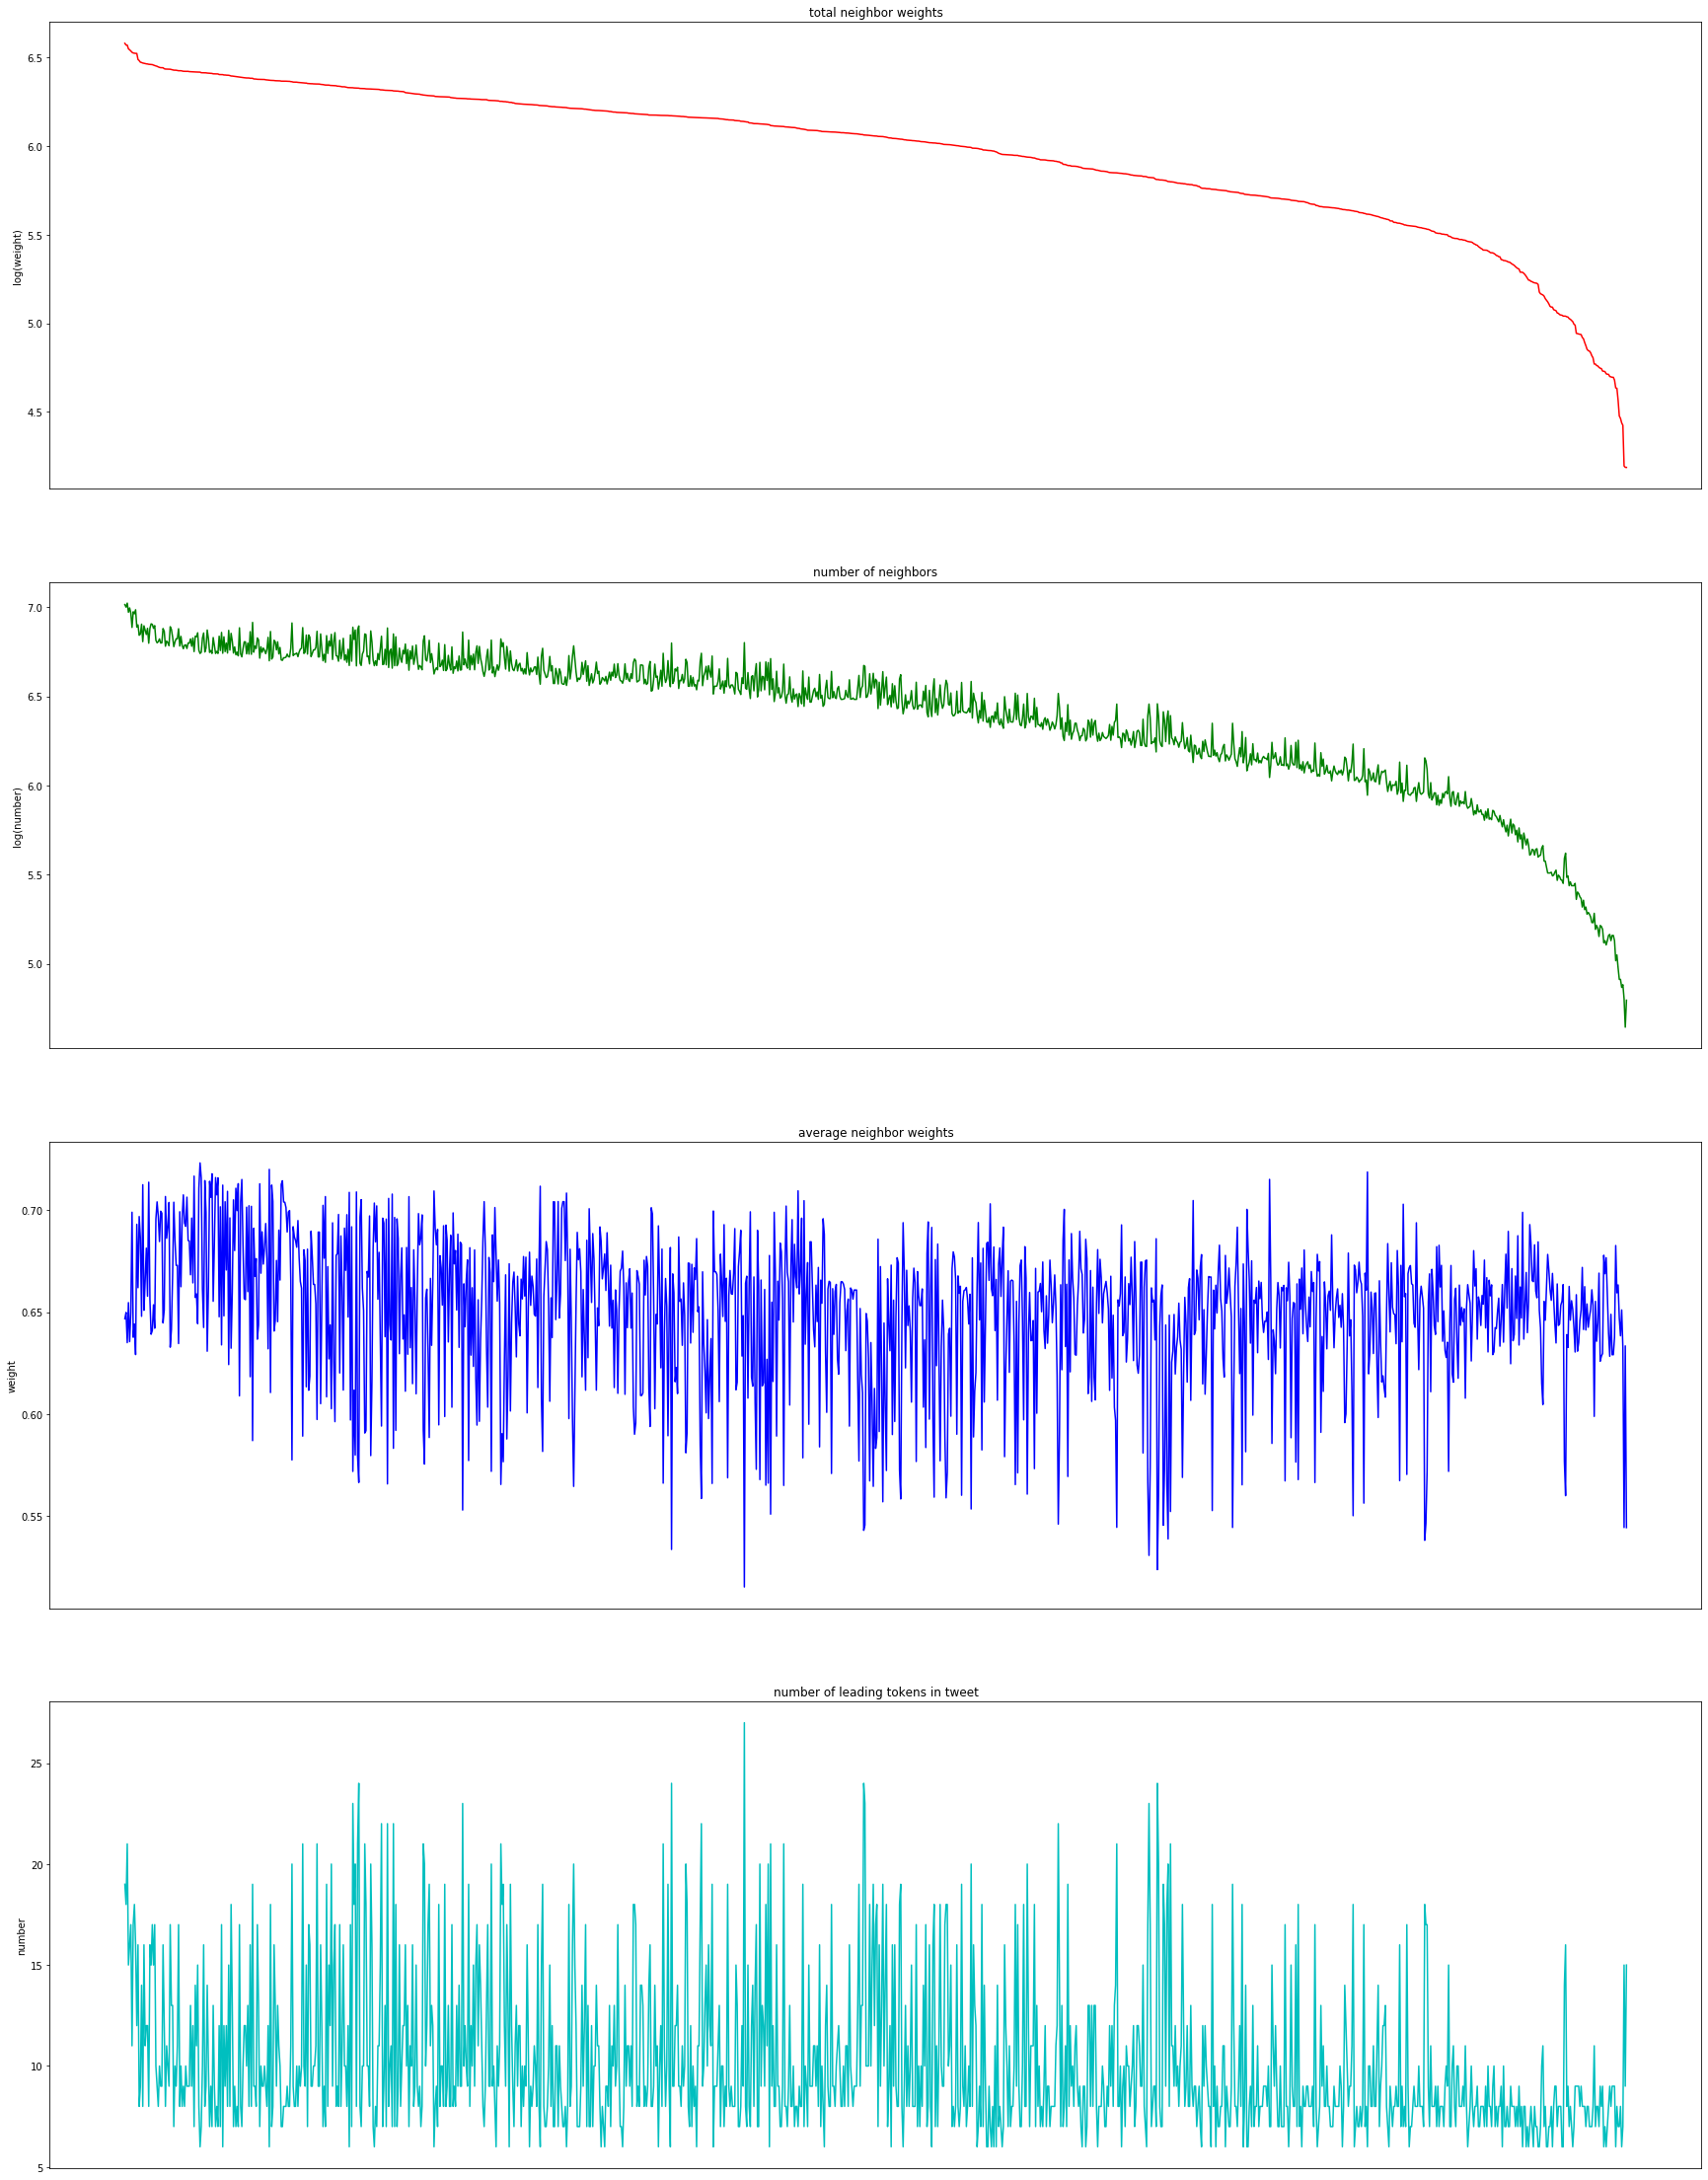

In [20]:
# plot some results here.... 

top_indices = graph_top_nodes.GetAllTweetIdx() 
x_axis = sorted(top_indices) 
y_total_weights = list()
y_avg_weights = list()
y_num_neighbors = list()
y_num_leading_tokens = list() 

for idx, total_weight in sorted_tweet_idx_to_total_weight:
    y_total_weights.append(np.log(total_weight))

for idx, _ in sorted_tweet_idx_to_total_weight:
    y_avg_weights.append(tweet_idx_to_avg_weight[idx])
    
for idx, _ in sorted_tweet_idx_to_total_weight:
    y_num_neighbors.append(np.log(tweet_idx_to_num_neighbors[idx]))
    
for idx, _ in sorted_tweet_idx_to_total_weight:
    y_num_leading_tokens.append(len(graph_top_nodes.GetTweetNode(idx).GetLeadingTokens()))

plt.figure(figsize=(30, 40))

plt.subplot(411)
plt.plot(y_total_weights, 'r')
plt.xticks(ticks=[])
plt.ylabel('log(weight)')
plt.title('total neighbor weights')

plt.subplot(412)
plt.plot(y_num_neighbors, 'g')
plt.xticks(ticks=[])
plt.ylabel('log(number)')
plt.title('number of neighbors')

plt.subplot(413)
plt.plot(y_avg_weights, 'b')
plt.xticks(ticks=[])
plt.ylabel('weight')
plt.title('average neighbor weights')

plt.subplot(414)
plt.plot(y_num_leading_tokens, 'c')
plt.xticks(ticks=[])
plt.ylabel('number')
plt.title('number of leading tokens in tweet')

plt.savefig('./plots/0225_tweet_graph_stats12.png')
plt.show()

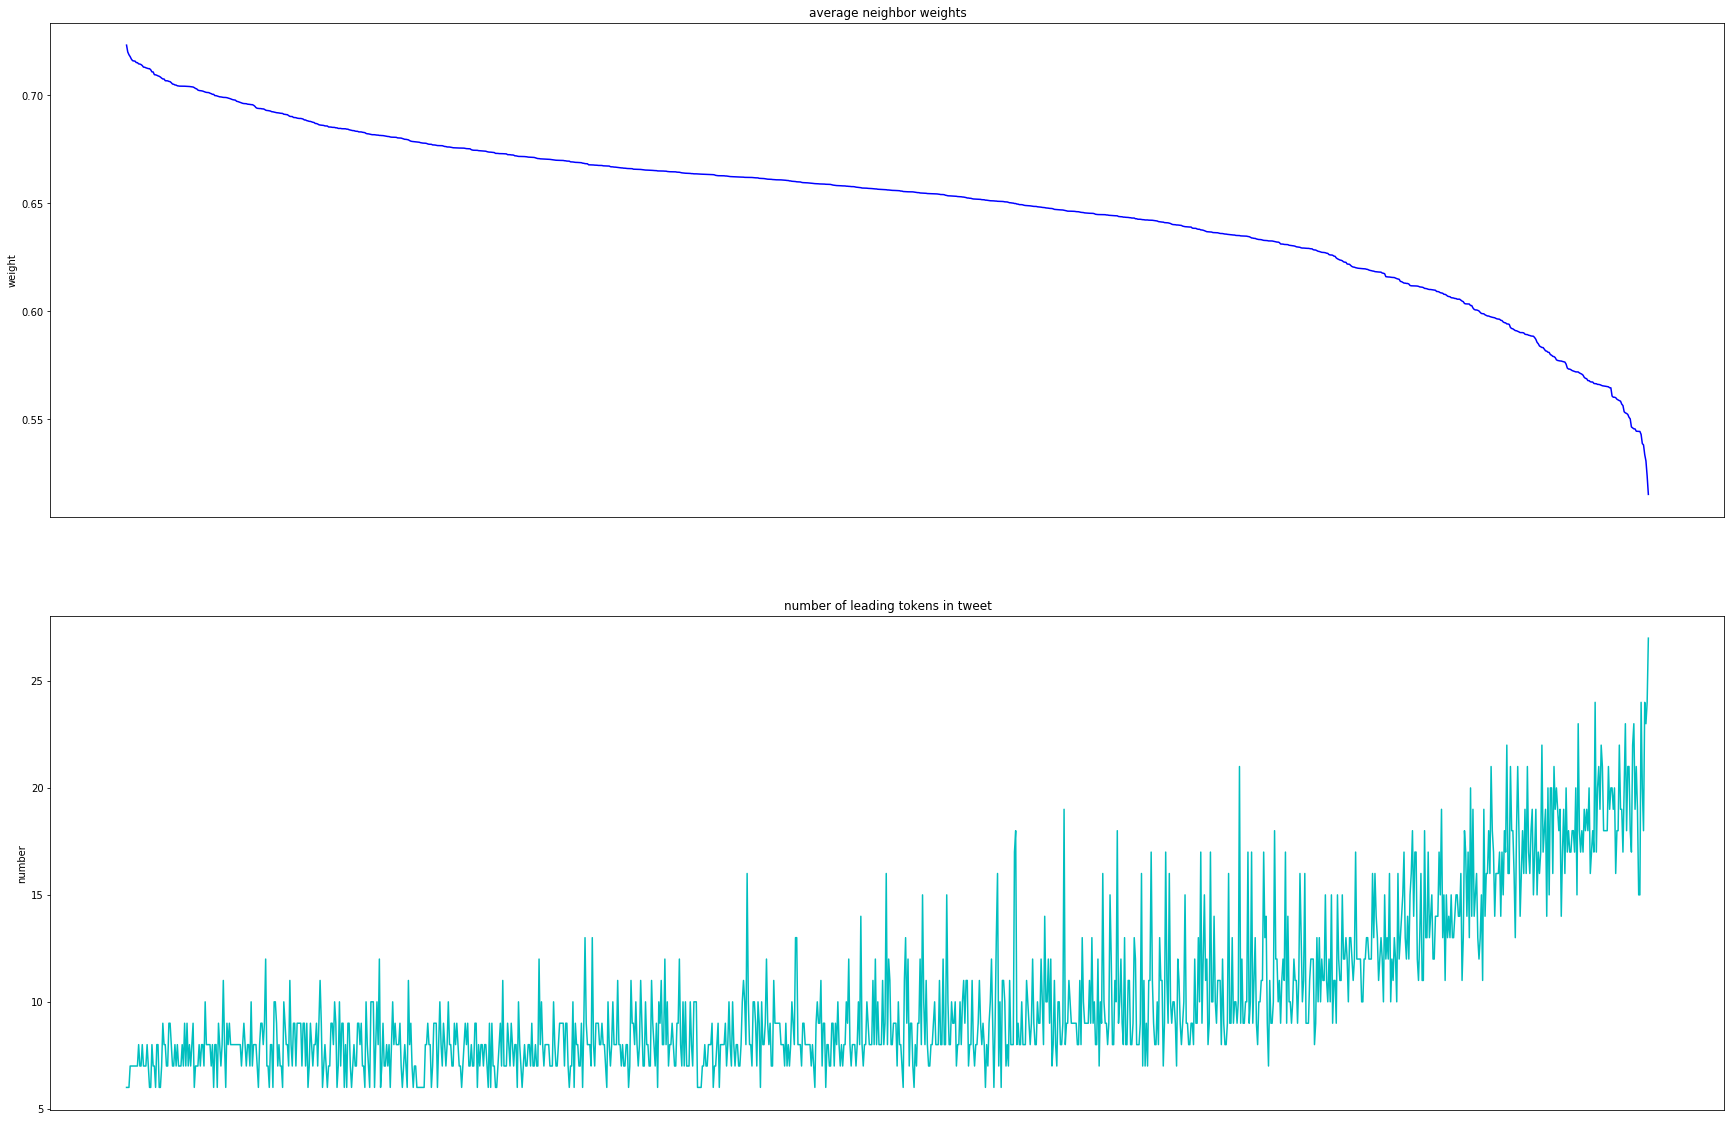

In [21]:
# more plots 

y_avg_weights = list()
y_num_leading_tokens = list() 

for idx, avg_weight in sorted_tweet_idx_to_avg_weight: 
    y_avg_weights.append(avg_weight)
    
for idx, _ in sorted_tweet_idx_to_avg_weight: 
    y_num_leading_tokens.append(len(graph_top_nodes.GetTweetNode(idx).GetLeadingTokens()))

plt.figure(figsize=(30, 20))

plt.subplot(211)
plt.plot(y_avg_weights, 'b')
plt.xticks(ticks=[])
plt.ylabel('weight')
plt.title('average neighbor weights')

plt.subplot(212)
plt.plot(y_num_leading_tokens, 'c')
plt.xticks(ticks=[])
plt.ylabel('number')
plt.title('number of leading tokens in tweet')

plt.savefig('./plots/0225_tweet_graph_stats3.png')
plt.show()

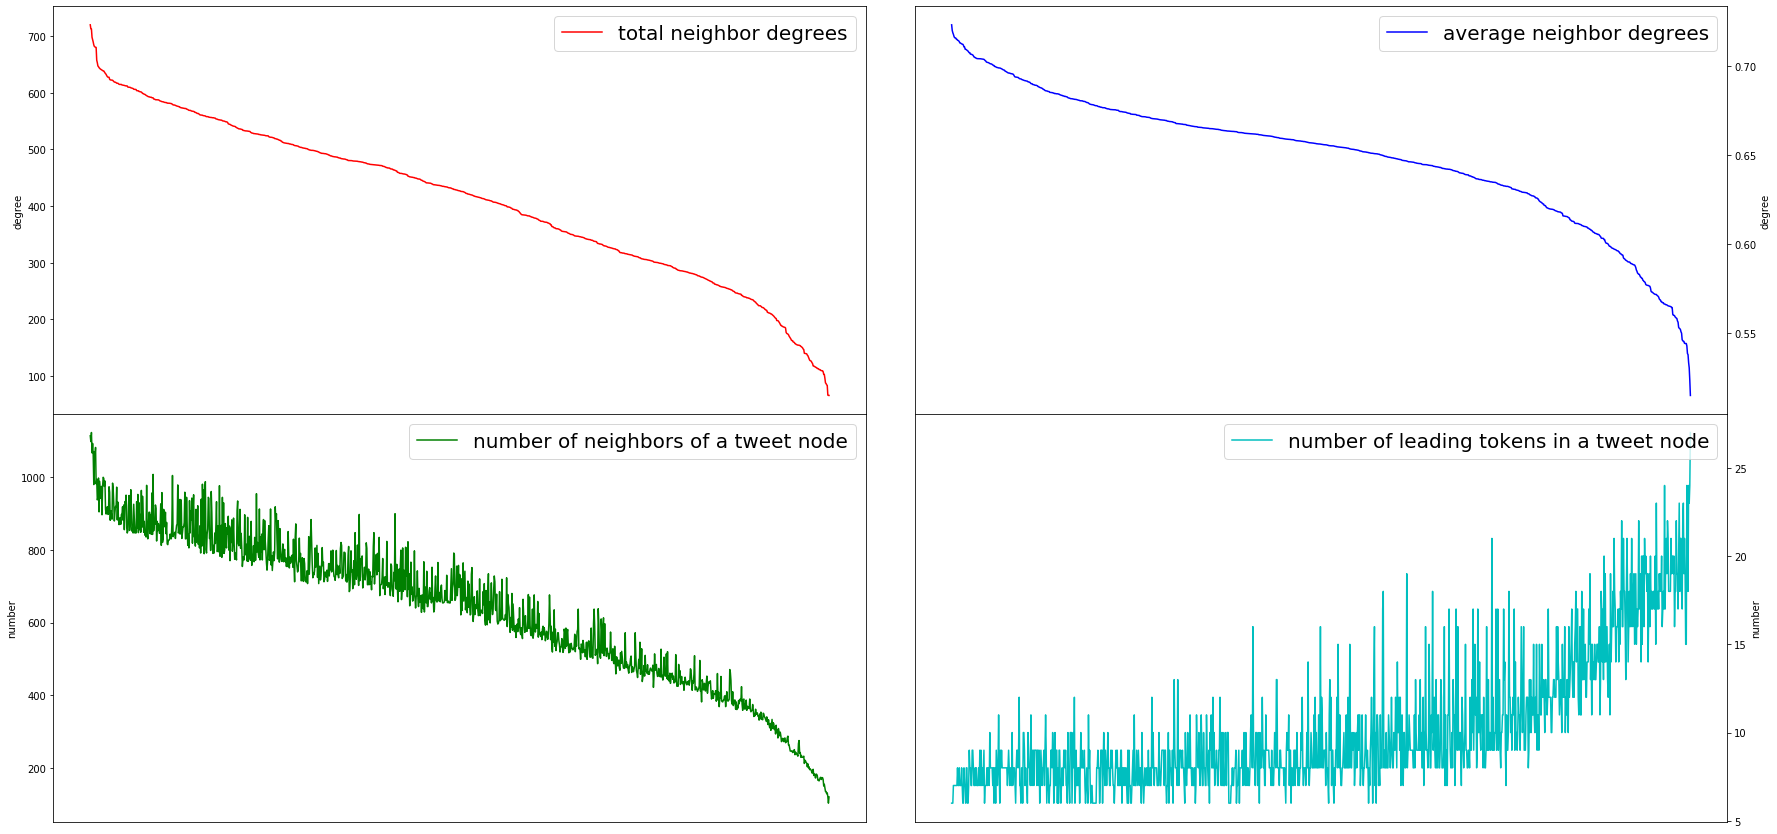

In [22]:
# plot for paper.... 

import matplotlib.gridspec as gridspec

top_indices = graph_top_nodes.GetAllTweetIdx() 
x_axis = sorted(top_indices) 
y_total_weights = list()
y_num_neighbors = list()

y_avg_weights = list()
y_num_leading_tokens = list() 

for idx, total_weight in sorted_tweet_idx_to_total_weight:
    y_total_weights.append(total_weight)
    
for idx, _ in sorted_tweet_idx_to_total_weight:
    y_num_neighbors.append(tweet_idx_to_num_neighbors[idx])
    
for idx, avg_weight in sorted_tweet_idx_to_avg_weight: 
    y_avg_weights.append(avg_weight)
    
for idx, _ in sorted_tweet_idx_to_avg_weight: 
    y_num_leading_tokens.append(len(graph_top_nodes.GetTweetNode(idx).GetLeadingTokens()))

plt.figure(figsize=(30, 15))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.06, hspace=0) # set the spacing between axes. 

ax00 = plt.subplot(gs1[0])
ax00.plot(y_total_weights, color='r', label='total neighbor degrees')
plt.xticks(ticks=[])
plt.ylabel('degree')
plt.legend(fontsize=20)

ax10 = plt.subplot(gs1[2])
ax10.plot(y_num_neighbors, color='g', label='number of neighbors of a tweet node')
plt.xticks(ticks=[])
plt.ylabel('number')
plt.legend(fontsize=20)

ax01 = plt.subplot(gs1[1])
ax01.plot(y_avg_weights, color='b', label='average neighbor degrees')
ax01.yaxis.set_label_position("right")
ax01.yaxis.tick_right()
plt.xticks(ticks=[])
plt.ylabel('degree')
plt.legend(fontsize=20)

ax11 = plt.subplot(gs1[3])
ax11.plot(y_num_leading_tokens, color='c', label='number of leading tokens in a tweet node')
ax11.yaxis.set_label_position("right")
ax11.yaxis.tick_right()
plt.xticks(ticks=[])
plt.ylabel('number')
plt.legend(fontsize=20, loc='upper right')

plt.savefig('./plots/0225_top_mi_degree_distribution.png')
plt.show()

In [24]:
# plot graphx plot
graph_nx = nx.Graph() 

# add all nodes to network nx graph 
for idx in graph_top_nodes.GetAllTweetIdx(): 
    leading_tokens = graph_top_nodes.GetTweetNode(idx).GetLeadingTokens() 
    num_tweet_merged = len(graph_top_nodes.GetTweetNode(idx).GetMergedTweetIndices())
    graph_nx.add_node(idx, leading_tokens=leading_tokens, num_tweet_merged=num_tweet_merged) 

# add all edges to network nx graph 
for idx in graph_top_nodes.GetAllTweetIdx():
    tweet_node = graph_top_nodes.GetTweetNode(idx)
    for weight, neighbor_node in tweet_node.GetWeightedNeighbors(): 
        neighbor_idx = neighbor_node.GetTweetIndex()
        graph_nx.add_edge(idx, neighbor_idx, weight=weight) 

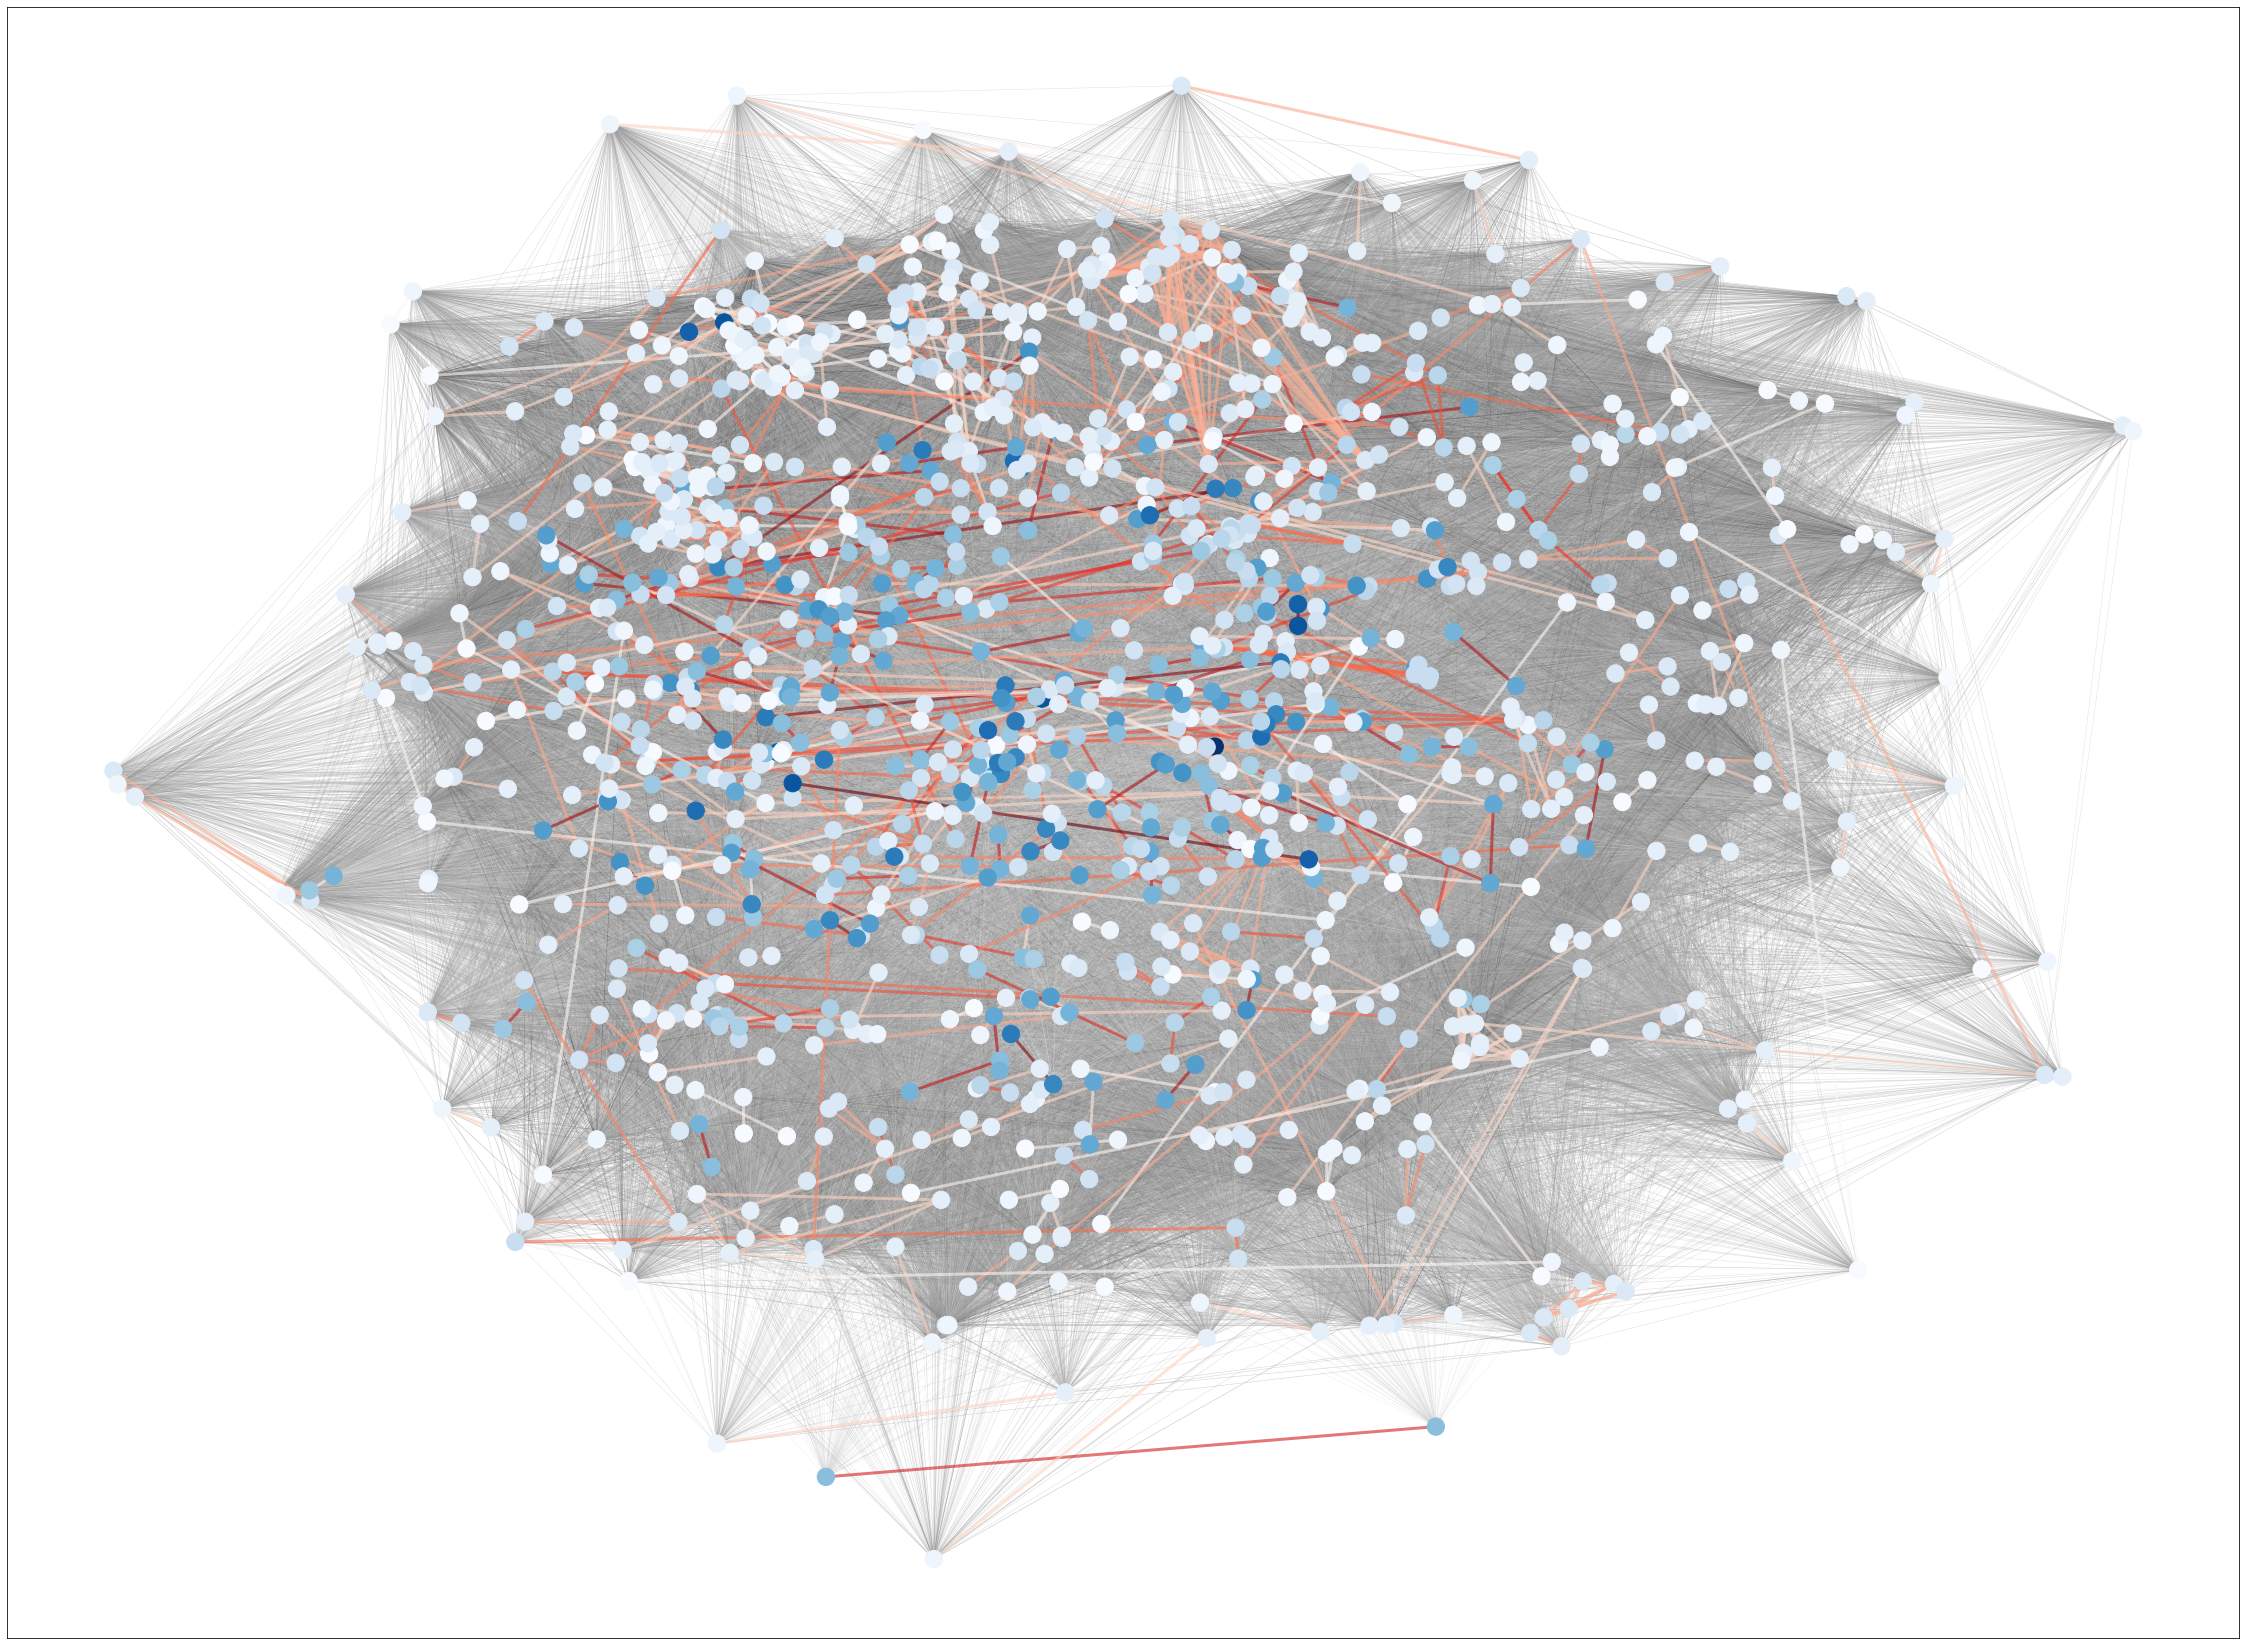

In [25]:
# draw the graph 
plt.figure(figsize=(40, 30))
pos = nx.layout.spring_layout(graph_nx)
top_1000_mis = sorted(top_1000_mis, key=lambda x: x[1])
min_top_1000_mi = top_1000_mis[0][1]

edge_large = [(u, v) for (u, v, d) in graph_nx.edges(data=True) if d['weight'] >= min_top_1000_mi]
edge_small = [(u, v) for (u, v, d) in graph_nx.edges(data=True) if d['weight'] < min_top_1000_mi]

node_colors = [len(graph_nx.nodes[n]['leading_tokens']) for n in graph_nx.nodes]
edge_colors_large = [graph_nx.edges[e]['weight'] for e in graph_nx.edges if graph_nx.edges[e]['weight'] >= min_top_1000_mi]
edge_colors_small = [graph_nx.edges[e]['weight'] for e in graph_nx.edges if graph_nx.edges[e]['weight'] < min_top_1000_mi]

nodes = nx.draw_networkx_nodes(graph_nx, pos, node_color=node_colors, cmap=plt.cm.Blues)

edges = nx.draw_networkx_edges(graph_nx, pos, edgelist=edge_small, edge_color=edge_colors_small, alpha=0.3, width=0.5, edge_cmap=plt.cm.Greys)
edges = nx.draw_networkx_edges(graph_nx, pos, edgelist=edge_large, edge_color=edge_colors_large, alpha=0.6, width=3, edge_cmap=plt.cm.Reds)

plt.savefig('./plots/0225_tweet_graph_plot.png')


In [23]:
# graph with only the top 1000 MI edges and the nodes
graph_nx_top_mi_edges_only = nx.Graph() 

# add all nodes to network nx graph 
for idx in graph_top_nodes.GetAllTweetIdx(): 
    leading_tokens = graph_top_nodes.GetTweetNode(idx).GetLeadingTokens() 
    num_tweet_merged = len(graph_top_nodes.GetTweetNode(idx).GetMergedTweetIndices())
    graph_nx_top_mi_edges_only.add_node(idx, leading_tokens=leading_tokens, num_tweet_merged=num_tweet_merged) 

# add all edges to network nx graph 
for idx_pair, mi in top_1000_mis:
    idx_pair = idx_pair.split(',')
    idx1 = int(idx_pair[0])
    idx2 = int(idx_pair[1])
    graph_nx_top_mi_edges_only.add_edge(idx1, idx2, weight=mi) 

In [24]:
# try finding cliques for the top 1000 mi only graph 
cliques_itr = nx.find_cliques(graph_nx_top_mi_edges_only)
cliques = list() 
for c in cliques_itr: 
    cliques.append(c)

In [25]:
sorted_cliques = sorted(cliques, key=lambda x: len(x), reverse=True)

In [26]:
count_large_cliques = 0
for c in sorted_cliques:
    if len(c) <= 2: break
    count_large_cliques += 1

In [27]:
print('number of cliques: ' + str(len(cliques)))
print('number of cliques with more than 2 nodes: ' + str(count_large_cliques))
print('largest clique: ' + str(len(sorted_cliques[0])))

number of cliques: 634
number of cliques with more than 2 nodes: 83
largest clique: 14


In [28]:
# check the clique contents
clique_tokens_dict = dict() 
for idx in sorted_cliques[0]:
    leading_tokens = graph.GetTweetNode(idx).GetLeadingTokens()
    leading_tokens = sorted(leading_tokens)
    print(idx, leading_tokens)
    
    for token in leading_tokens:
        if not token in clique_tokens_dict:
            clique_tokens_dict[token] = 0
        clique_tokens_dict[token] += 1
        
print('\n')
print(clique_tokens_dict)

1805 ['#bitcoinprice', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'marketwatch', 'probably', 'slide']
28096 ['#bitcoinprice', '#stockmarket', '#thetrumpocalypse', 'best', 'crashing', 'gdx', 'history', 'probably', 'slide']
38120 ['#bitcoinprice', '#epidemic', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'probably', 'slide']
33545 ['#bitcoinprice', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'probably', 'slide', 'unemployment']
31947 ['#bitcoinprice', '#stockmarket', 'best', 'crashing', 'dystopian', 'gdx', 'history', 'probably', 'slide']
7533 ['#bitcoinprice', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'probably', 'providing', 'slide']
21709 ['#bitcoinprice', '#politics', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'probably', 'slide']
333 ['#bitcoinprice', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'probably', 'slide', 'update']
37789 ['#bitcoinprice', '#stockmarket', 'best', 'crashing', 'gdx', 'history', 'lmaoooo', 'probably

In [29]:
print(graph.GetTweetNode(16400).GetTweetText())

{'tanking', 'history', 'slide', 'dow', 'point', 'worst', 'market', 'coronavirus', '2day', 'one', 'stock', 'logged', 'reason'}
